In [29]:
import pandas as pd
import folktables as ft
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os
import glob
import re

In [2]:
results_dir = '../domain-adaptive-trees/results'

In [12]:
states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
          'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
          'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
          'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
          'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


scores_dicts = pickle.load(open( "accuracy_dicts.pkl", "rb" ))
confusion_dicts = pickle.load(open( "equal_opp_dicts.pkl", "rb" ))


# load dicts into a dict with source state as key
def load_all_dicts(result='scores'):
    all_dicts = {}
    for file in os.listdir(results_dir):
        if file.startswith(result):
            results_dict = pickle.load(open(os.path.join(
                results_dir, file), 'rb'))    
            for key, values in results_dict.items():
                source_state = key[0]
                target_state = key[1]
                if source_state not in all_dicts.keys():
                    all_dicts[source_state] = {}
                all_dicts[source_state][target_state] = values                   
    return all_dicts


# make table of sorted accuracy of each state on task (source==target),EO
def get_no_shift_values(scores_dicts, confusion_dicts):
    no_shift_dict = {}
    for key, values in scores_dicts.items():
        # access state == target values
        try:
            acc = values[key][0]
        except:
            acc = None
        try:
            eo = confusion_dicts[key][key][0]
        except:
            eo = None
        # todo: put in a check that those things stay the same across lambda
        no_shift_dict[key] = [acc, eo]
    return no_shift_dict


# Next, get accuracy shift for each state to state comparison?
def find_best_domain_shift_accuracy(scores_dicts):
## For each (source, target) find 'best' lambda for goal metric
    tops_dict = {}
    for source_key, source_value in scores_dicts.items():
        # source value is dict every target state for this source state')
        for target_key, target_value in source_value.items():
            # target_value is accuracy for each lamba for this source target')
            top = 0
            for lmda, value in target_value.items():
#                 if value >= top:
                if abs(scores_dicts[source_key][source_key][lmda]-value) >=top:
                    top = value # source_key,source_key,lmda-value
                    top_keys = (source_key, target_key)
                    top_values = [lmda, top]
            tops_dict.update({top_keys:top_values})
    return tops_dict
            
            
def add_best_domain_shift_EO(confusion_dicts, tops_dict):
    for source_key, source_value in confusion_dicts.items():
        # source value is dict every target state for this source state')
        for target_key, target_value in source_value.items():
            # target_value is accuracy for each lamba for this source target')
            top = 2.1
            for lmda, value in target_value.items():
#                 if abs(value) < top:
                if abs(scores_dicts[source_key][source_key][lmda]-value):
                    top = value
                    top_eo_values = [lmda, value]
            top_values = tops_dict[source_key, target_key]
            top_values.append(top_eo_values[0])
            top_values.append(top_eo_values[1])
#             print(top_values)  
            tops_dict[source_key, target_key] = top_values
#             print(tops_dict[source_key, target_key])
    print(tops_dict[source_key, target_key])

    return tops_dict



no_shift_dict = get_no_shift_values(scores_dicts, confusion_dicts)
no_shift_df = pd.DataFrame.from_dict(no_shift_dict, orient='index',  
                                     columns=['Accuracy', 'Equal Opportunity']).sort_values(by=['Accuracy'], 
                                                                                            ascending=False)


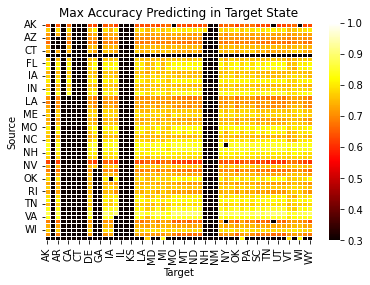

In [248]:
# accuracy scores by source, target
def df_accuracy_source_target():
    df = pd.DataFrame(columns=states, index=states)
    for key, value in scores_dicts.items():
        for k, v in value.items():
            df[key][k] = max(v.values())
    df = df.replace({np.nan:-10})
    return df


# accuracy scores by source, target
def df_accuracy_source_target_normalized():
    df = pd.DataFrame(columns=states, index=states)
    for key, value in scores_dicts.items():
        try:
            base_accuracy = max(value[key])
        except:
            base_accuracy = 1000
        for k, v in value.items():
            df[key][k] = max(v.values()) - base_accuracy
    df = df.replace({np.nan:-1000})
    return df


# eo scores by source, target
def df_eo_source_target():
    df = pd.DataFrame(columns=states, index=states)
    for key, value in confusion_dicts.items():
        for k, v in value.items():
            df[key][k] = max(v.values())
    df = df.replace({np.nan:100})
    return df

    
df_a = df_accuracy_source_target()   
ax_a = sns.heatmap(df_a, linewidth=0.5, vmin=0.3, vmax=1.0, cmap='hot')

ax_a.set(xlabel='Target', ylabel='Source', title='Max Accuracy Predicting in Target State')

# df_b = df_accuracy_source_target_normalized()
# ax_b = sns.heatmap(df_b, linewidth=0.5, vmin=-0.5, vmax=0.1, cmap='RdGy', center=0)


plt.show()